<a href="https://colab.research.google.com/github/JackF-O/Cascaded-CNN-and-Object-Detection/blob/main/Drone%20Routing/Drone_Routing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install DeepForest

In [ ]:
!pip uninstall numpy
!pip install numpy

In [ ]:
from deepforest import deepforest
from deepforest import deepforest
from deepforest import preprocess
from deepforest import utilities
from deepforest import __version__

In [ ]:
model = deepforest.deepforest()

In [ ]:
model.use_release()

In [ ]:
!pip install geopandas

In [ ]:
import numpy as np
from PIL import Image
import os
from matplotlib import pyplot as plt
import shapely
import geopandas


In [ ]:
raster_path = '/content/drive/MyDrive/image_crop.tif'
raster = Image.open(raster_path)
numpy_image = np.array(raster)
numpy_image.shape

(1739, 2511, 3)

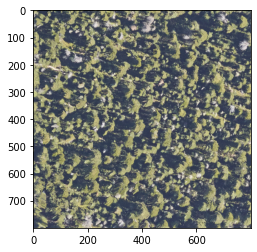

In [ ]:
windows = preprocess.compute_windows(numpy_image, patch_size=800,patch_overlap=0.1)
index = 9
crop = numpy_image[windows[index].indices()]
crop.shape
plt.imshow(crop)
plt.savefig('trees.pdf')

In [ ]:
crop1 = crop[...,::-1]

In [ ]:
prediction = model.predict_image(numpy_image = crop1,return_plot=True, score_threshold=0.05)

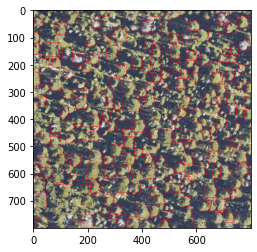

In [ ]:
plt.imshow(prediction[...,::-1])
plt.savefig('trees_identified.pdf')

In [ ]:
prediction_boxes = model.predict_image(numpy_image = crop1,return_plot=False, score_threshold=0.05)

In [ ]:
print(prediction_boxes)

           xmin        ymin        xmax        ymax     score label
0    752.088806   22.442945  792.090393   65.628662  0.751168  Tree
1    205.633881  512.548645  253.248611  561.476685  0.699744  Tree
2    353.726685  327.817261  395.861938  373.806519  0.684034  Tree
3    137.464340  527.470215  175.990234  567.862305  0.667669  Tree
4    532.784119  360.604187  563.093262  393.052002  0.664836  Tree
..          ...         ...         ...         ...       ...   ...
195  748.518982  260.670990  773.704041  289.025330  0.352616  Tree
196  471.496033  262.745026  499.008423  290.096741  0.352539  Tree
197   40.863083  577.778870   73.484192  612.994202  0.352466  Tree
198  410.344147  114.742210  439.053070  146.136917  0.350555  Tree
199  725.443420  136.747513  752.165283  163.885956  0.349680  Tree

[200 rows x 6 columns]


In [ ]:
points = []
for index, row in prediction_boxes.iterrows():
        x = row['xmin']+(row['xmax'] - row['xmin'])/2
        y = row['ymin']+(row['ymax'] - row['ymin'])/2
        points.append((x,y))

In [ ]:
print(points)

[(772.089599609375, 44.03580379486084), (229.44124603271484, 537.0126647949219), (374.7943115234375, 350.8118896484375), (156.72728729248047, 547.666259765625), (547.9386901855469, 376.8280944824219), (402.64068603515625, 735.8179321289062), (765.1490783691406, 213.89586639404297), (775.6952819824219, 126.92380142211914), (221.01004028320312, 594.29736328125), (420.9065856933594, 60.8487606048584), (315.8974304199219, 735.3196411132812), (540.6026306152344, 577.68701171875), (484.71241760253906, 785.8613891601562), (680.40380859375, 763.3588256835938), (308.0135192871094, 514.6582336425781), (127.27623748779297, 308.4201965332031), (541.2751770019531, 269.89076232910156), (134.75666427612305, 427.8050079345703), (650.6134338378906, 662.9067687988281), (484.8152313232422, 237.84812927246094), (138.3494110107422, 470.1702575683594), (277.30499267578125, 550.5141906738281), (500.0482940673828, 751.0487060546875), (492.02015686035156, 465.78582763671875), (387.8749542236328, 426.1794891357

In [ ]:
import networkx as nx
import math
from itertools import combinations

In [ ]:
G = nx.Graph()

In [ ]:
for i in points:
  G.add_node(i, pos=i)

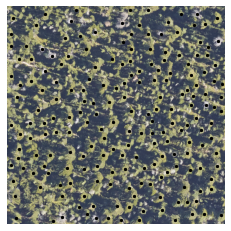

In [ ]:
plt.imshow(crop)
nx.draw(G, nx.get_node_attributes(G, 'pos'), node_size=5, node_color='black')
plt.savefig('trees_networked.pdf')

In [ ]:
print(len(points))

200


In [ ]:
points_sorted = sorted(points, key=lambda x: x[0])

In [ ]:
bounds = list(range(0,850,50))

In [ ]:
points_bounded = []
count = 0
for i in range(len(bounds)-1):
  bounded = []
  for j in range(len(points_sorted)):
    if bounds[i] <= points_sorted[j][0] <= bounds[i+1]:
      bounded.append(points_sorted[j])
  if count % 2 == 0:
    bounded = sorted(bounded, key=lambda x: x[1])
  else:
    bounded = sorted(bounded, key=lambda x: x[1], reverse=True)
  count += 1
  points_bounded.append(bounded)
bounded_points = [item for sublist in points_bounded for item in sublist]

In [ ]:
G = nx.Graph()

for i in points_sorted:
  G.add_node(i, pos=i)

for i in range(len(bounded_points)-1):
    start = bounded_points[i]
    end = bounded_points[i+1]
    dist = abs(math.hypot(end[0] - start[0], end[1] - start[1]))
    G.add_edge(start, end, weight=dist)
# G.remove_edge(bounded_points[0], bounded_points[199])

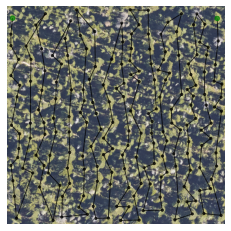

In [ ]:
plt.imshow(crop)
ec = ['g' if (u==bounded_points[0]) or (u==bounded_points[199]) else 'none' for u, v in G.nodes(data=True)]
es = [20 if (u==bounded_points[0]) or (u==bounded_points[199]) else 5 for u, v in G.nodes(data=True)]
nx.draw(G, nx.get_node_attributes(G, 'pos'), alpha=0.7, node_color=ec, node_size=es)
plt.savefig('trees_routed.pdf')